# Quantized FACILE Training with Brevitas
This notebook walks through the steps to train and and validate the Pytorch Brevitas reconstruction of the HCAL Facile model

Initial Pytorch conversion by Vladimir Oveckhin
Pytorch to Brevitas conversion by Matthew Trahms

In [1]:
#install pandas (missing in FINN env)
!pip install --user pandas

In [1]:
#import the necessary classes and functions
from train import train
from metrics import Metrics
from quant_model import QuantNet
from quant_modelV2 import QuantNet_opt
#from quantmodelV2_with_proc import QuantNet_opt_proc

In [2]:
models_folder = 'quant_models'

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Number of batches per epoch: 460
# of Model parameters: 983.0
# of features: 14


Epoch 1
Ave Train Loss: 0.0007208682848111141
Ave Val Loss: 0.00045083634966664214
Ave Q Train Loss: 0.8215781565181762
Ave Q Val Loss: 0.48800113539175227
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.00045083634966664214
Saved model


Epoch 2
Ave Train Loss: 0.0004102733328297483
Ave Val Loss: 0.00041483551932211353
Ave Q Train Loss: 0.4630585109005814
Ave Q Val Loss: 0.46609186916758155
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.00041483551932211353
Saved model


Epoch 3
Ave Train Loss: 0.0003822529718907856
Ave Val Loss: 0.0003820063605895231
Ave Q Train Loss: 0.4290159440663594
Ave Q Val Loss: 0.4091699557142844
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.0003820063605895231
Saved model



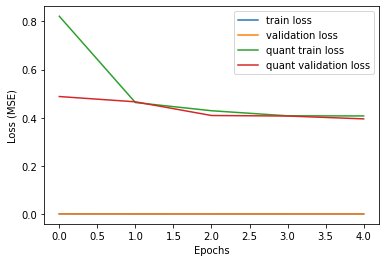

<class 'quant_modelV2.QuantNet_opt'>


In [3]:
#train (mimicing structure in train.py)
metrics = Metrics()
model = None
try:
    model = train(QuantNet_opt, metrics=metrics, models_folder_path=models_folder, quantized=True)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    metrics.plot_losses()
print(type(model))

In [4]:
#test inference
import torch
import utils
from torch.utils.data import DataLoader
from processing_for_train import FACILE_preproc as preproc
from processing_for_train import FACILE_postproc as postproc
from processing_for_train import FACILE_preproc_out as preproc_out

batch_size=1
train_set, val_set, test_set, n_features = utils.load_torch_datasets()
gen_params = {
                "batch_size": batch_size,
                "shuffle": True,
            }
test_gen = DataLoader(test_set, **gen_params)
#ensure model in evaluation mode
model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0
total_test_loss_quant = 0
n_test_samples = 0

for test_batch, labels_batch in test_gen:
    n_test_samples += test_batch.shape[0]

    labels_batch_q = labels_batch
    labels_batch = preproc_out(labels_batch.float())
    output_batch = preproc(test_batch.float())
    output_batch = model(output_batch)
    #output_batch = postproc(output_batch).float()
    #output_batch = torch.trunc(output_batch)
    output_batch_quant = torch.round(output_batch)
    output_batch_quant = postproc(output_batch_quant)
    q_loss = loss_fn(output_batch_quant.float(), labels_batch_q.float())
    total_test_loss_quant += q_loss.item()
    loss = loss_fn(output_batch.float(), labels_batch.float())
    total_test_loss += loss.item()

ave_test_loss = total_test_loss / n_test_samples
ave_test_loss_q = total_test_loss_quant / n_test_samples

print(f"Ave Test Loss: {ave_test_loss}")
print(f"Ave Q Test Loss: {ave_test_loss_q}")

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Ave Test Loss: 0.17105999569405586
Ave Q Test Loss: 185.71323337686624


In [5]:
#export to onnx finn format
from brevitas.onnx import export_finn_onnx
input_shape = [1,14]
export_finn_onnx(model, input_shape, models_folder + "/facileV3_4b_1.onnx")